In [2]:
import os
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
# Define the root dataset path
path = r"C:\Users\YAMANI\OneDrive\Desktop\pollen_classification\dataset"

In [3]:
# Get all .jpg files from subdirectories
image_paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith(".jpg"):
            image_paths.append(os.path.join(root, file))


Number of images: 790


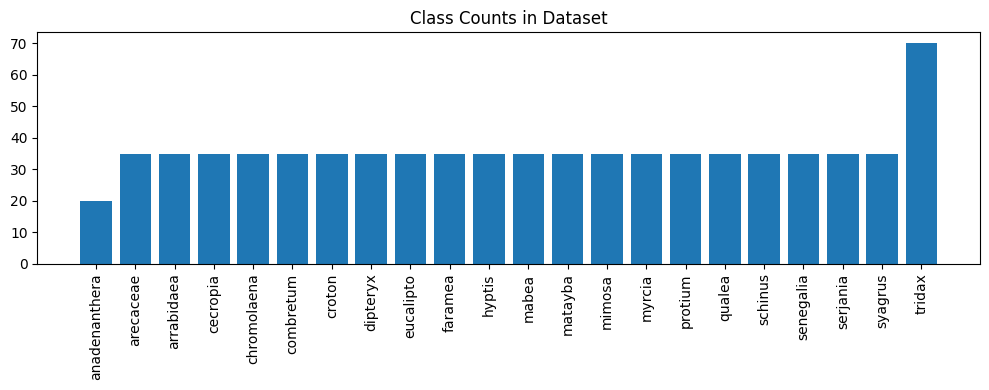

In [4]:
# Assume folder name is the class (i.e., path/.../<class_name>/image.jpg)
names = [os.path.basename(os.path.dirname(img_path)) for img_path in image_paths]
classes = Counter(names)
print("Number of images:", len(image_paths))
plt.figure(figsize=(10, 4))
plt.title('Class Counts in Dataset')
plt.bar(*zip(*classes.items()))
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


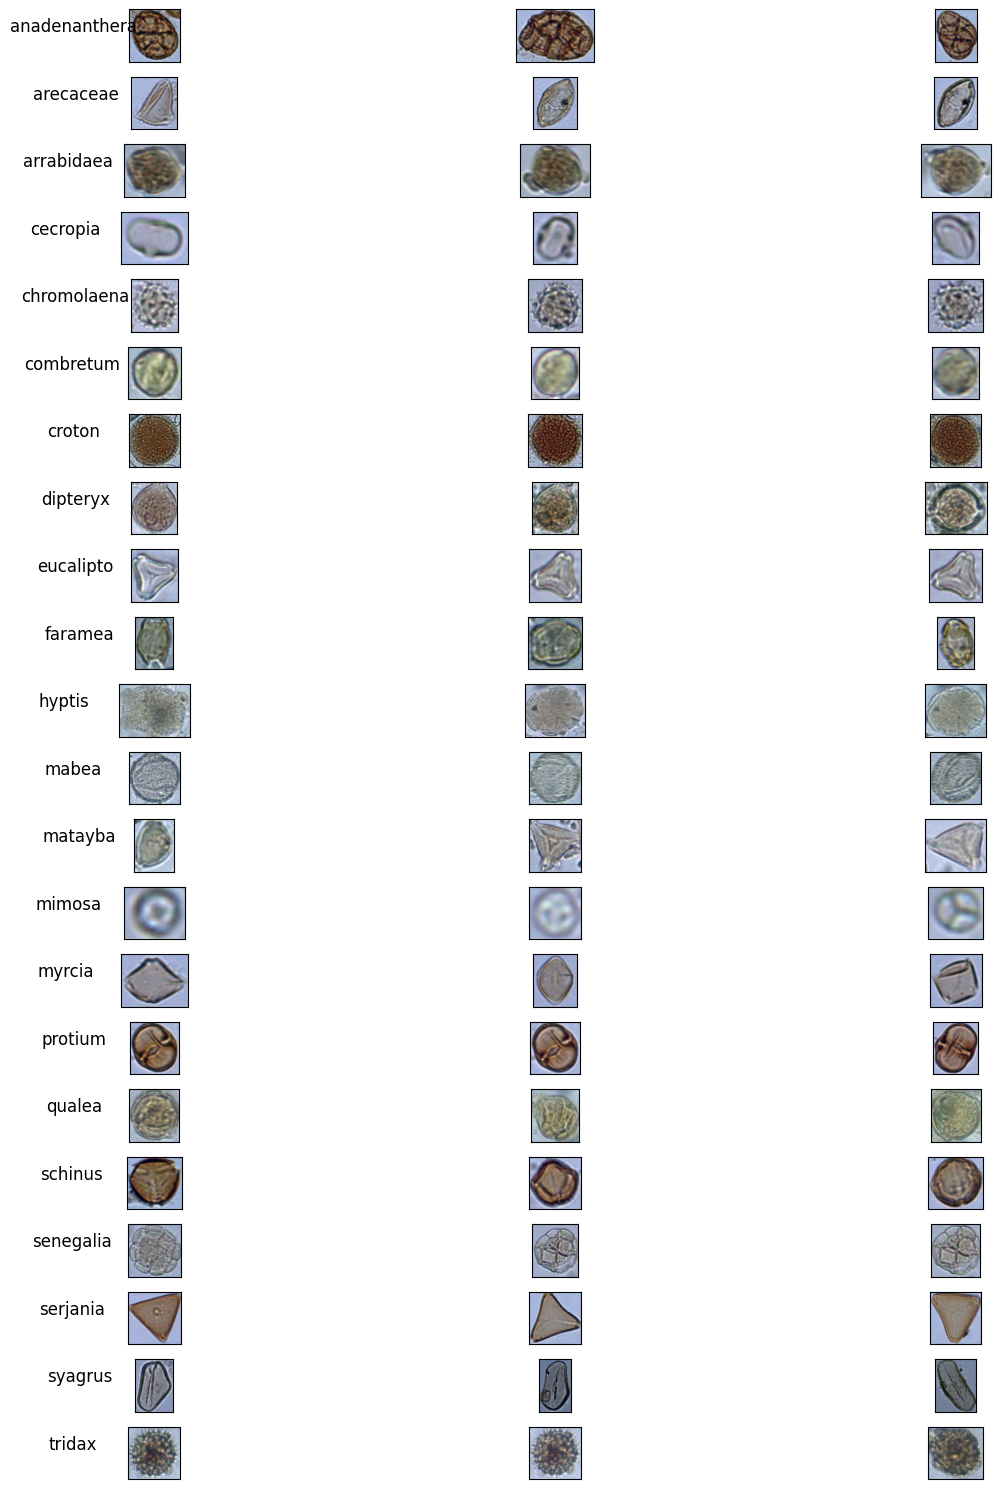

In [5]:
path_class = {key: [] for key in classes.keys()}
for img_path in image_paths:
    key = os.path.basename(os.path.dirname(img_path))
    path_class[key].append(img_path)
fig = plt.figure(figsize=(15, 15))

for i, key in enumerate(path_class.keys()):
    for j in range(min(3, len(path_class[key]))):
        img = Image.open(path_class[key][j])
        ax = fig.add_subplot(len(path_class), 3, 3*i + j + 1, xticks=[], yticks=[])
        ax.imshow(img)
        if j == 0:
            ax.set_ylabel(key, rotation=0, size='large', labelpad=40)

plt.tight_layout()
plt.show()


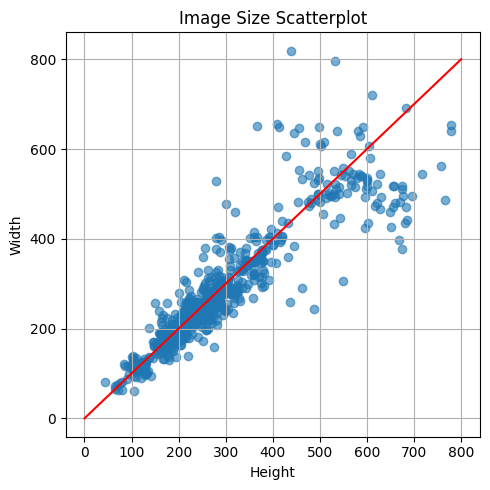

In [7]:
import cv2

size = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith(".jpg"):
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)
            if img is not None:
                size.append(img.shape)

x, y, _ = zip(*size)

fig = plt.figure(figsize=(5, 5))
plt.scatter(x, y, alpha=0.6)
plt.title("Image Size Scatterplot")
plt.xlabel("Height")
plt.ylabel("Width")
plt.grid(True)
plt.plot([0, 800], [0, 800], 'r')
plt.tight_layout()
plt.show()


In [9]:
# Data pre processing

import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def process_img(img, size=(128, 128)):
    # Convert BGR to RGB since cv2 reads in BGR format
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize and normalize
    img_resized = cv2.resize(img_rgb, size)
    return img_resized.astype(np.float32) / 255.0


In [ ]:
# FIXED: Collect data with consistent class labeling
X, Y = [], []
valid_extensions = ['.jpg', '.jpeg', '.png']

for root, dirs, files in os.walk(path):
    # Skip the root directory itself
    if root == path:
        continue
    
    for file in files:
        if any(file.lower().endswith(ext) for ext in valid_extensions):
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)
            if img is not None:
                try:
                    processed_img = process_img(img)
                    X.append(processed_img)
                    # Use the immediate parent directory as class label
                    class_name = os.path.basename(root)
                    Y.append(class_name)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue

print(f"Total images loaded: {len(X)}")
print(f"Classes found: {set(Y)}")
print(f"Class distribution: {Counter(Y)}")


Total images loaded: 790
Classes found: {'arrabidaea', 'faramea', 'matayba', 'senegalia', 'cecropia', 'syagrus', 'urochloa', 'qualea', 'mabea', 'chromolaena', 'tridax', 'serjania', 'dipteryx', 'eucalipto', 'mimosa', 'croton', 'arecaceae', 'hyptis', 'protium', 'combretum', 'anadenanthera', 'myrcia', 'schinus'}
Class distribution: Counter({'arecaceae': 35, 'arrabidaea': 35, 'cecropia': 35, 'chromolaena': 35, 'combretum': 35, 'croton': 35, 'dipteryx': 35, 'eucalipto': 35, 'faramea': 35, 'hyptis': 35, 'mabea': 35, 'matayba': 35, 'mimosa': 35, 'myrcia': 35, 'protium': 35, 'qualea': 35, 'schinus': 35, 'senegalia': 35, 'serjania': 35, 'syagrus': 35, 'tridax': 35, 'urochloa': 35, 'anadenanthera': 20})


In [ ]:
# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

# FIXED: Proper label encoding
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print(f"Class mapping: {dict(zip(le.classes_, range(num_classes)))}")

# FIXED: Stratified split with proper test size
X_train, X_test, Y_train_encoded, Y_test_encoded = train_test_split(
    X, Y_encoded, 
    test_size=0.2,  # More reasonable test size
    stratify=Y_encoded,
    random_state=42  # For reproducibility
)

# Convert to categorical
Y_train = to_categorical(Y_train_encoded, num_classes)
Y_test = to_categorical(Y_test_encoded, num_classes)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels shape: {Y_train.shape}")
print(f"Test labels shape: {Y_test.shape}")

# Print class distribution
unique_train, counts_train = np.unique(Y_train_encoded, return_counts=True)
unique_test, counts_test = np.unique(Y_test_encoded, return_counts=True)
print("Training set class distribution:", dict(zip(unique_train, counts_train)))
print("Test set class distribution:", dict(zip(unique_test, counts_test)))


Number of classes: 23
Class mapping: {'anadenanthera': 0, 'arecaceae': 1, 'arrabidaea': 2, 'cecropia': 3, 'chromolaena': 4, 'combretum': 5, 'croton': 6, 'dipteryx': 7, 'eucalipto': 8, 'faramea': 9, 'hyptis': 10, 'mabea': 11, 'matayba': 12, 'mimosa': 13, 'myrcia': 14, 'protium': 15, 'qualea': 16, 'schinus': 17, 'senegalia': 18, 'serjania': 19, 'syagrus': 20, 'tridax': 21, 'urochloa': 22}
Training set shape: (632, 128, 128, 3)
Test set shape: (158, 128, 128, 3)
Training labels shape: (632, 23)
Test labels shape: (158, 23)
Training set class distribution: {0: 16, 1: 28, 2: 28, 3: 28, 4: 28, 5: 28, 6: 28, 7: 28, 8: 28, 9: 28, 10: 28, 11: 28, 12: 28, 13: 28, 14: 28, 15: 28, 16: 28, 17: 28, 18: 28, 19: 28, 20: 28, 21: 28, 22: 28}
Test set class distribution: {0: 4, 1: 7, 2: 7, 3: 7, 4: 7, 5: 7, 6: 7, 7: 7, 8: 7, 9: 7, 10: 7, 11: 7, 12: 7, 13: 7, 14: 7, 15: 7, 16: 7, 17: 7, 18: 7, 19: 7, 20: 7, 21: 7, 22: 7}


In [1]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np

# Step 1: Encode labels (folder names)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(labels)  # 'labels' must be a list of folder names

# Step 2: One-hot encode the labels
Y_onehot = to_categorical(Y_encoded)

# Step 3: Split into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_onehot, test_size=0.2, random_state=42)

# Step 4: Get class indices for computing weights
Y_train_encoded = np.argmax(Y_train, axis=1)

# Step 5: Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train_encoded),
    y=Y_train_encoded
)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)


NameError: name 'labels' is not defined

In [ ]:


# FIXED: Improved model architecture
model = Sequential()

# First block
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

# Second block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

# Third block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

# Fourth block (optional, remove if overfitting)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

# Classifier
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


NameError: name 'Sequential' is not defined

In [ ]:
# FIXED: Better optimizer settings
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Start with higher learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# FIXED: More conservative data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,        # Reduced rotation
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'       # Better fill mode
)

# FIXED: Add callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
]

# Fit the data generator
datagen.fit(X_train)

# FIXED: Better training parameters
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=100,  # Reduced epochs, let early stopping handle it
    validation_data=(X_test, Y_test),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
19/19 [==============================] - 63s 3s/step - loss: 3.7682 - accuracy: 0.0783 - val_loss: 3.5315 - val_accuracy: 0.0506 - lr: 0.0010
Epoch 2/100
19/19 [==============================] - 52s 3s/step - loss: 3.1182 - accuracy: 0.1600 - val_loss: 3.7261 - val_accuracy: 0.0380 - lr: 0.0010
Epoch 3/100
19/19 [==============================] - 45s 2s/step - loss: 2.6734 - accuracy: 0.2233 - val_loss: 4.6710 - val_accuracy: 0.0443 - lr: 0.0010
Epoch 4/100
19/19 [==============================] - 39s 2s/step - loss: 2.3753 - accuracy: 0.3050 - val_loss: 4.4979 - val_accuracy: 0.0443 - lr: 0.0010
Epoch 5/100
19/19 [==============================] - 39s 2s/step - loss: 2.2186 - accuracy: 0.3233 - val_loss: 4.7818 - val_accuracy: 0.0696 - lr: 0.0010
Epoch 6/100
19/19 [==============================] - ETA: 0s - loss: 1.9673 - accuracy: 0.3883
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
19/19 [==============================] - 41s 2s/step - los

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# FIXED: Save model with better naming
model.save("pollen_classification_model.h5")
print("Model saved as pollen_classification_model.h5")


Test Accuracy: 0.4557
Test Loss: 3.5663


c:\Users\srini\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as pollen_classification_model.h5


In [ ]:
# FIXED: Save label encoder for future predictions
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Label encoder saved as label_encoder.pkl")


Label encoder saved as label_encoder.pkl


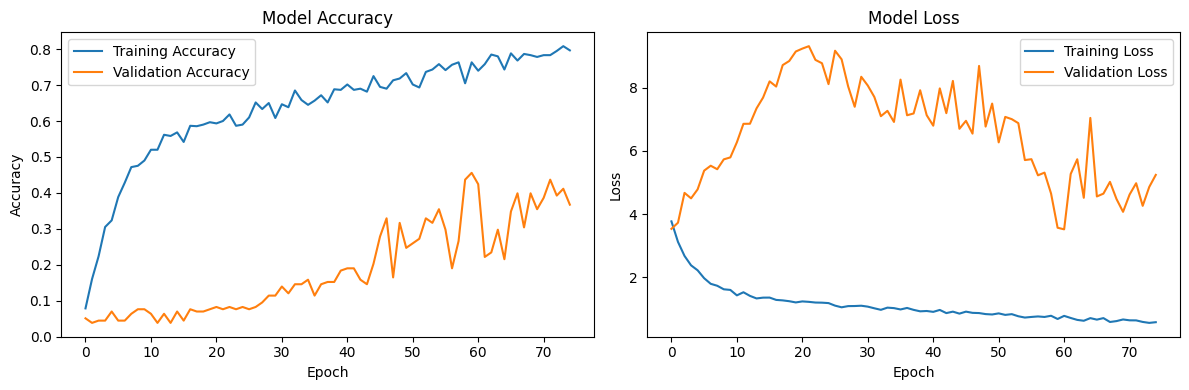

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# FIXED: Add prediction function for testing
def predict_image(model, image_path, label_encoder):
    """
    Predict the class of a single image
    """
    img = cv2.imread(image_path)
    if img is None:
        return None, None
    
    # Preprocess the image the same way as training data
    processed_img = process_img(img)
    img_batch = np.expand_dims(processed_img, axis=0)
    
    # Make prediction
    predictions = model.predict(img_batch, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    return predicted_class, confidence


In [ ]:
# Test prediction on a few images
print("\nTesting predictions on some images:")
for i, img_path in enumerate(image_paths[:5]):  # Test first 5 images
    true_class = os.path.basename(os.path.dirname(img_path))
    pred_class, confidence = predict_image(model, img_path, le)
    print(f"Image: {os.path.basename(img_path)}")
    print(f"True class: {true_class}, Predicted: {pred_class}, Confidence: {confidence:.4f}")
    print("---")



Testing predictions on some images:
Image: anadenanthera_16.jpg
True class: anadenanthera, Predicted: tridax, Confidence: 0.5683
---
Image: anadenanthera_17.jpg
True class: anadenanthera, Predicted: tridax, Confidence: 0.6311
---
Image: anadenanthera_18.jpg
True class: anadenanthera, Predicted: tridax, Confidence: 0.8277
---
Image: anadenanthera_19.jpg
True class: anadenanthera, Predicted: tridax, Confidence: 0.7226
---
Image: anadenanthera_20.jpg
True class: anadenanthera, Predicted: tridax, Confidence: 0.7849
---
